In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras import optimizers
#from tensorflow.keras.preprocessing import image
import os
from sklearn.model_selection import train_test_split
import shutil
import random
import math
import numpy as np
import zipfile
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def prepare_dataset(X_dataset, y_dataset, classes, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    df_aux = pd.DataFrame(columns=['id', 'label'])

    list_aux = []

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        sample = {'id':nm_file, 'label':str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')}
        list_aux.append(sample)

    return pd.concat([df_aux, pd.DataFrame(list_aux)], ignore_index=True)


def create_files(X_dataset, y_dataset, classes, dir, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        img = X_dataset[i]
        plt.imsave(dir + nm_file, img)


def create_directory(dir):
    if os.path.exists(dir):
        for file in os.listdir(dir):
            os.remove(dir+file)
    else:
        os.makedirs(dir)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Esta função imprime e plota a matriz de confusão.
    A normalização pode ser aplicada definindo `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Label real')
    plt.xlabel('Label predito')        

In [3]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170498071/170498071 [==============================] - 9s 0us/step


In [4]:
train_dir = "./train/"
test_dir = "./test/" 

create_directory(train_dir)
create_directory(test_dir)

In [64]:
train_samples = 250 #X_train.shape[0]

create_files(X_train, y_train, cifar10_classes, train_dir, train_samples)

train_df = prepare_dataset(X_train, y_train, cifar10_classes, train_samples)

train_df.head()

,id,label
0,0-frog.png,frog
1,1-truck.png,truck
2,2-truck.png,truck
3,3-deer.png,deer
4,4-automobile.png,automobile


In [65]:
test_samples = 100 #X_test.shape[0]

create_files(X_test, y_test, cifar10_classes, test_dir, test_samples)

test_df = prepare_dataset(X_test, y_test, cifar10_classes, test_samples)

test_df.head()

,id,label
0,0-cat.png,cat
1,1-ship.png,ship
2,2-ship.png,ship
3,3-airplane.png,airplane
4,4-frog.png,frog


In [66]:
print('Total de imagens para treinamento: %s' % len(os.listdir(train_dir)))
print('Total de imagens para teste      : %s' % len(os.listdir(test_dir)))

Total de imagens para treinamento: 250
Total de imagens para teste      : 100


In [67]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 188 validated image filenames belonging to 10 classes.
Found 62 validated image filenames belonging to 10 classes.


In [68]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_dir,
x_col="id",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32))

Found 100 validated image filenames belonging to 10 classes.


In [69]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(32,32,3), activation=('relu')))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation=('relu')))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation=('relu')))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation=('relu')))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 8, 8, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 4, 4, 128)       

In [70]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
train_step_size = train_generator.n//train_generator.batch_size
validation_step_size = valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=5
)

Epoch 1/5
5/5 [==============================] - 6s 527ms/step - loss: 2.3105 - accuracy: 0.1125 - val_loss: 2.3208 - val_accuracy: 0.1250
Epoch 2/5
5/5 [==============================] - 1s 162ms/step - loss: 2.2604 - accuracy: 0.1731 - val_loss: 2.4781 - val_accuracy: 0.1250
Epoch 3/5
5/5 [==============================] - 1s 164ms/step - loss: 2.2737 - accuracy: 0.1923 - val_loss: 2.3319 - val_accuracy: 0.0312
Epoch 4/5
5/5 [==============================] - 1s 168ms/step - loss: 2.2108 - accuracy: 0.2051 - val_loss: 2.4590 - val_accuracy: 0.1562
Epoch 5/5
5/5 [==============================] - 1s 167ms/step - loss: 2.1747 - accuracy: 0.2308 - val_loss: 2.4217 - val_accuracy: 0.1250


In [72]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1
    
    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == len(test_generator)+1:
        break
        
    else:
        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model.predict(images)

        # Visualização da imagem
        for i in range(len(images)):
            
            image = images[i]
            label = labels[i]

            prediction = predictions[i]
        
            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]

            labeled_class = np.argmax(label)    
            label = class_names[int(labeled_class)]

            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            # class_name = 'dog' if prediction >= 0.5 else 'cat'

            class_name = class_names[int(predicted_class)]

            y_pred.append(class_name)
        
            # # Configura a saída das imagens que serão visualizadas
            # plt.figure(figsize=(.5, .5))
            # plt.imshow(image)
            # plt.axis('Off')
            # plt.show()

            print('%s : %s : %f' % (label, class_name, probability))

1/1 [==============================] - 0s 274ms/step
cat : frog : 0.208641
ship : automobile : 0.199992
ship : ship : 0.200689
airplane : automobile : 0.186959
frog : frog : 0.199381
frog : frog : 0.253702
automobile : frog : 0.249842
frog : frog : 0.196946
cat : frog : 0.191317
automobile : automobile : 0.203220
airplane : ship : 0.177940
truck : frog : 0.181748
dog : frog : 0.214389
horse : frog : 0.213583
truck : automobile : 0.178203
ship : frog : 0.166916
dog : frog : 0.209163
horse : frog : 0.207430
ship : automobile : 0.194262
frog : frog : 0.265892
horse : frog : 0.191977
airplane : automobile : 0.191758
deer : ship : 0.205138
truck : frog : 0.295394
dog : frog : 0.224426
bird : frog : 0.184453
deer : frog : 0.226010
airplane : truck : 0.166828
truck : frog : 0.174166
frog : frog : 0.263725
frog : frog : 0.213801
dog : frog : 0.214523
1/1 [==============================] - 0s 81ms/step
deer : frog : 0.179649
dog : frog : 0.206507
truck : automobile : 0.183190
bird : frog : 0.18

In [73]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.210000  ;  loss = 2.225336 


In [74]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

Accuracy:  0.21
Precision:  0.09313461538461539
Recall:  0.21
F1 Score:  0.10835273368606702


Matriz de confusão sem normalização


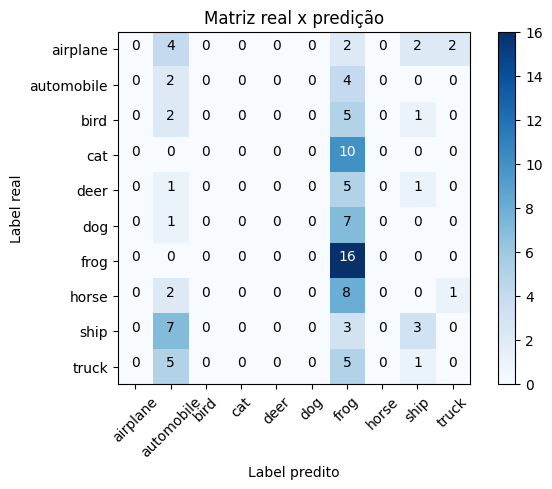

In [75]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, 
                      classes=cifar10_classes,
                      normalize= False, 
                      title='Matriz real x predição')

In [76]:
loss, accuracy = model.evaluate_generator(generator=valid_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.161290  ;  loss = 2.383851 


In [77]:
test_generator.reset()
pred=model.predict_generator(test_generator)

predicted_class_indices=np.argmax(pred,axis=1)

In [78]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [79]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)